In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ERROR: Could not find a version that satisfies the requirement collections.abc
ERROR: No matching distribution found for collections.abc


In [52]:
from qiskit import QuantumCircuit
# from qiskit.circuit import Diagonal
# from qiskit.circuit.library.generalized_gates import diagonal as Diagonal
from qiskit.circuit.library import Diagonal
# from . import diagonal
# from qiskit.circuit.quantumcircuit import Diagonal
from collections.abc import Iterable
from math import sqrt,pi

In [53]:
def initialize( qc: QuantumCircuit, qubits: Iterable):
    for q in qubits:
        qc.h(q)
    return qc

In [101]:
def generalized_oracle(n: int, desired: int):
    diagonal_elements = [1]*(2**n)
    diagonal_elements[desired] = -1
    oracle_gate = Diagonal(diagonal_elements)
    oracle_gate.name = f"Oracle\nn={n}\ns=$|{format(desired, '0%ib' % n)}\\rangle$ (={desired})"
    return oracle_gate

def diffuser(nqubits:int, as_gate=True):
    qc= QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits-1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    if as_gate:
        U_s = qc.to_gate()
    else:
        U_s = qc
    U_s.name = "U$_s$"
    return U_s

def phase_flip_encode(nlogical: int
                      , physical1:Iterable, physical2: Iterable, physical3:Iterable):
    
    qc = QuantumCircuit(nlogical*3)
    for q in range(nlogical):
        qc.cx(physical1[q], physical2[q])
        qc.cx(physical1[q], physical3[q])
        qc.h(physical1[q])
        qc.h(physical2[q])
        qc.h(physical3[q])
    return qc

def phase_flip_decode(nlogical: int
                      , physical1:Iterable, physical2: Iterable, physical3:Iterable):
    
    qc = QuantumCircuit(nlogical*3)
    # 2 logical qubits
    for q in range(nlogical):
        qc.cx(physical1[q], physical2[q])
        qc.cx(physical1[q], physical3[q])
        qc.ccx(physical3[q], physical2[q], physical1[q])
    return qc

def uncorrected_grover(n: int, desired: int):
    qc = QuantumCircuit( n,n )
    all_wires = range(n)
    initialize(qc, all_wires)
    grover_oracle = generalized_oracle( n, desired)
    grover_diffuser = diffuser(n)
    N = 2**n
    reps = int(pi/4*sqrt(N))
    for i in range(reps):
        qc.append(grover_oracle, all_wires)
        qc.append(grover_diffuser, all_wires)
    qc.measure( all_wires, all_wires)
    return qc

def phase_flip_error_corrected_grover(n: int, desired: int, force_one_error: bool = False):
    wires = [[],[],[]]
    for i in [0, 1, 2]:
        wires[i] = range(i*n, (i+1)*n)
    all_wires = range(n*3)
    qc = QuantumCircuit(n*3, n)
    pfenc = phase_flip_encode(n, wires[0], wires[1], wires[2])
    print(pfenc)
    return pfenc
    pfenc.name = 'Phase flip correction encode'
    qc.append(pfenc, all_wires)
    
    qc.barrier()

    grover_oracle = generalized_oracle(n, desired)

    grover_diffuser = diffuser(n)

    N = 2**n

    if force_one_error:
        group = np.random.randint(3)
        wire = np.random.radint(n)
        qc.z(wires[group][wire])
    reps = int(pi/4**sqrt(N))
    for i in range(reps):
        qc.append(grover_oracle, wires[0])
        qc.append(grover_diffuser, wires[0])
        qc.append(grover_oracle, wires[1])
        qc.append(gorver_difuser, wires[1])
        qc.append(grover_oracle, wires[2])
        qc.append(grover_diffuser , wires[2])
    
    qc.barrier()
    pfdec = phase_flip_decode(n, wires[0], wires[1], wires[2])
    
    pfdec.name = 'Phase flip correction'
    print(pfdec)
    qc.append(pfdec, all_wires)
    qc.measure(wires[0], wires[0])
    return qc
    
        

In [111]:
wires = [[], [], []]
for i in [0, 1, 2]:
    wires[i] = range(i*2, (i+1)*2)
    
print(wires[0][0])
# phase_flip_encode(2, wires[0], wires[1], wires[2]).draw()

0


                    ┌───┐          
q_0: ──■─────────■──┤ H ├──────────
       │         │  └───┘     ┌───┐
q_1: ──┼────■────┼─────────■──┤ H ├
     ┌─┴─┐  │    │  ┌───┐  │  └───┘
q_2: ┤ X ├──┼────┼──┤ H ├──┼───────
     └───┘┌─┴─┐  │  ├───┤  │       
q_3: ─────┤ X ├──┼──┤ H ├──┼───────
          └───┘┌─┴─┐├───┤  │       
q_4: ──────────┤ X ├┤ H ├──┼───────
               └───┘└───┘┌─┴─┐┌───┐
q_5: ────────────────────┤ X ├┤ H ├
                         └───┘└───┘


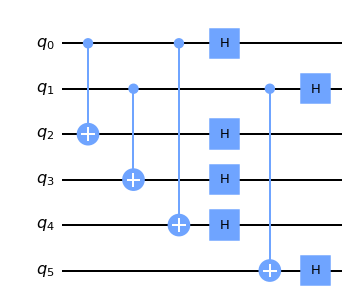

In [103]:
phase_flip_error_corrected_grover(2, 1).draw()